# Product Utilization and Engagement

## Importing the libraries 

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Importing the datasets

In [9]:
df_product = pd.read_csv("../staging/data_set/cleaned_product.csv")
df_util = pd.read_csv("../staging/data_set/cleaned_utilization_eda.csv")
df_exp = pd.read_csv("../staging/data_set/cleaned_expansion.csv")

## Convert date

In [10]:
for df in [df_product, df_util, df_exp]:
    df["score_date"] = pd.to_datetime(df["score_date"], errors="coerce")
    df["year_month"] = df["score_date"].dt.to_period("M").astype(str)

## Compute Product Churn

In [11]:
df_product.sort_values(["id", "year_month"], inplace=True)


def compute_churn(df, col):
    prev = df.groupby("id")[col].shift(1)
    churn = ((prev == 1) & (df[col] == 0)).astype(int)
    return churn


# Calculate churn for each product tier and a combined churn signal
df_product["team_churn"] = compute_churn(df_product, "team_plus")
df_product["pro_churn"] = compute_churn(df_product, "pro_plus")
df_product["ent_churn"] = compute_churn(df_product, "ent_plus")
df_product["churn_total"] = (
    df_product["team_churn"] + df_product["pro_churn"] + df_product["ent_churn"] > 0
).astype(int)

## Calculate the change in utilization

In [12]:
df_util["seat_utilization_change"] = (
    df_util["seat_utilization"] - df_util["seat_utilization_M_before"]
)

## Merge the Datasets

In [13]:
df_merged = pd.merge(
    df_product,
    df_util[["id", "year_month", "seat_utilization_change"]],
    on=["id", "year_month"],
    how="inner",
)

## Visualization

C:\Users\puvvu\AppData\Local\Temp\ipykernel_30236\1452939498.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


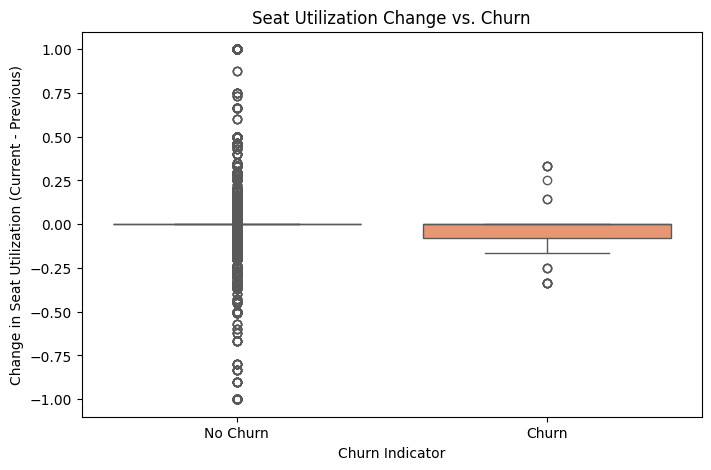

In [14]:
plt.figure(figsize=(8, 5))
sns.boxplot(
    data=df_merged, x="churn_total", y="seat_utilization_change", palette="Set2"
)
plt.xticks([0, 1], ["No Churn", "Churn"])
plt.title("Seat Utilization Change vs. Churn")
plt.xlabel("Churn Indicator")
plt.ylabel("Change in Seat Utilization (Current - Previous)")
plt.show()